In [1]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr


/tmp/ipykernel_3910996/3749613158.py:36: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [2]:
# !sleep 3h;

In [17]:
outdir="./output/"
csvfiles = os.listdir(outdir)
df = pd.DataFrame([])
# games = ["zincStep"]
games = ["zinc"]
seeds = ["51"]
# betas = ["0.9", "0.99", "0.999", "0.5","0.501", "0.901", "0.902", "0.903"]
betas = ["0.9", "0.999", "0.5"]
dbs = ["-20.0"]
for csvfile in csvfiles:
    if ".csv" not in csvfile:
        continue
    cfgs = csvfile[0:-4].split("_")
    if len(cfgs) < 9:
        continue
    env, optimizer, learning_rate, beta1, beta2, seed, db, eps = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5], cfgs[6], cfgs[7] 
    batchs = cfgs[9]
    if env not in games:
        continue
    if db not in dbs:
        continue
    if eps not in ["e1000"]:
        continue
    if batchs not in ["128"]:
        continue
    # if optimizer=="AdamPlus" and db=="-3":
    #     continue
    # if beta2 not in betas:
    #     continue
    if seed[4:] not in seeds:
        continue
#     if "Adam" in optimizer:
#         # optimizer=optimizer + db + "dB"
#         optimizer=optimizer + '_' + beta2
#     elif "Lamb" in optimizer:
#         # optimizer=optimizer + db + "dB"
#         optimizer=optimizer + '_' + beta2
    df_tmp = pd.read_csv(os.path.join(outdir, csvfile), index_col=0)
    df_tmp["env"] = env
    df_tmp["optimizer"] = optimizer
    df_tmp["learning_rate"]=learning_rate
    df_tmp["beta1"]=beta1
    df_tmp["beta2"]=beta2
    df_tmp["seed"]= seed
    df = pd.concat([df, df_tmp], ignore_index=False)
    print(csvfile[0:-4])

# df = df.reset_index()
df = df.reset_index(drop=True)
# df

zinc_Adam42_1.0e-04_0.9_0.999_seed51_-20.0_e1000_batch_128_sch0


In [18]:
df_tmp = df
for item in ["loss", "val_mae", "test_mae", "lr"]: 
    # Add EMA (exponential moving average) of `item` column to df_tmp
    alpha = 0.05  # smoothing factor, tune this to adjust the amount of smoothing
    ema_col = f"{item}_ema"
    
    df_tmp[ema_col] = (
        df_tmp
        .groupby(["opt", "beta2", "beta1"])[item]
        .transform(lambda x: x.ewm(alpha=alpha).mean())
    )

res_df = df_tmp.groupby(["opt","beta1","beta2"])[["lr"]].min()
res_df2 = df_tmp.groupby(["opt","beta1","beta2"])[["epoch"]].max()
res_df3 = df_tmp.groupby(["opt","beta1","beta2"])[["loss_ema","val_mae_ema","test_mae_ema"]].min()
res_df = pd.concat([res_df, res_df2, res_df3], axis=1)
res_df = res_df.reset_index()
# res_df.to_csv(os.path.join(output_dir,"mnist_cnn_result_table.csv"))

pd.set_option('display.float_format', '{:.4f}'.format)

res_df.sort_values(by='loss_ema').reset_index(drop=True)

,opt,beta1,beta2,lr,epoch,loss_ema,val_mae_ema,test_mae_ema
0,Adam42,0.9,0.999,0.0001,1000,0.0431,0.1279,0.0999


In [14]:
outdir="./output/"
csvfiles = os.listdir(outdir)
df = pd.DataFrame([])
# games = ["zincStep"]
games = ["zinc"]
seeds = ["51"]
betas = ["0.9", "0.99", "0.999", "0.5","0.501", "0.901", "0.902", "0.903"]
dbs = ["-20.0"]
for csvfile in csvfiles:
    if ".csv" not in csvfile:
        continue
    cfgs = csvfile[0:-4].split("_")
    if len(cfgs) < 11:
        continue
    env, optimizer, learning_rate, beta1, beta2, seed, db, eps = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5], cfgs[6], cfgs[7] 
    batchs = cfgs[9]
    sch = cfgs[10]
    if env not in games:
        continue
    if db not in dbs:
        continue

    if eps not in ["e1000"]:
        continue
    if batchs not in ["128"]:
        continue
    # if optimizer=="AdamPlus" and db=="-3":
    #     continue
    # if beta2 not in betas:
    #     continue
    if seed[4:] not in seeds:
        continue

    if "Adam" in optimizer:
        # optimizer=optimizer + db + "dB"
        optimizer=optimizer + '_' + beta2
    elif "Lamb" in optimizer:
        # optimizer=optimizer + db + "dB"
        optimizer=optimizer + '_' + beta2
    df_tmp = pd.read_csv(os.path.join(outdir, csvfile), index_col=0)
    df_tmp["env"] = env
    df_tmp["optimizer"] = optimizer
    df_tmp["learning_rate"]=learning_rate
    df_tmp["beta1"]=beta1
    df_tmp["beta2"]=beta2
    df_tmp["seed"]= seed
    df = pd.concat([df, df_tmp], ignore_index=False)
    print(csvfile[0:-4])

# df = df.reset_index()
df = df.reset_index(drop=True)
df

zinc_Adam42_1.0e-04_0.9_0.999_seed51_-20.0_e1000_batch_128_sch0


,epoch,loss,val_mae,test_mae,lr,opt,env,optimizer,learning_rate,beta1,beta2,seed
0,1,0.986075,0.723281,0.711471,0.0001,Adam42,zinc,Adam42_0.999,1.0e-04,0.9,0.999,seed51
1,2,0.569480,0.514788,0.552007,0.0001,Adam42,zinc,Adam42_0.999,1.0e-04,0.9,0.999,seed51
2,3,0.504552,0.594470,0.620888,0.0001,Adam42,zinc,Adam42_0.999,1.0e-04,0.9,0.999,seed51
3,4,0.472346,0.495119,0.526500,0.0001,Adam42,zinc,Adam42_0.999,1.0e-04,0.9,0.999,seed51
4,5,0.439841,0.628704,0.648224,0.0001,Adam42,zinc,Adam42_0.999,1.0e-04,0.9,0.999,seed51
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0.043105,0.131780,0.095095,0.0001,Adam42,zinc,Adam42_0.999,1.0e-04,0.9,0.999,seed51
996,997,0.039395,0.134968,0.102935,0.0001,Adam42,zinc,Adam42_0.999,1.0e-04,0.9,0.999,seed51
997,998,0.043420,0.156064,0.117786,0.0001,Adam42,zinc,Adam42_0.999,1.0e-04,0.9,0.999,seed51
998,999,0.052051,0.132084,0.098849,0.0001,Adam42,zinc,Adam42_0.999,1.0e-04,0.9,0.999,seed51


../fig/zinc_seed51e1000_loss.pdf
../fig/zinc_seed51e1000_val_mae.pdf
../fig/zinc_seed51e1000_test_mae.pdf
../fig/zinc_seed51e1000_lr.pdf


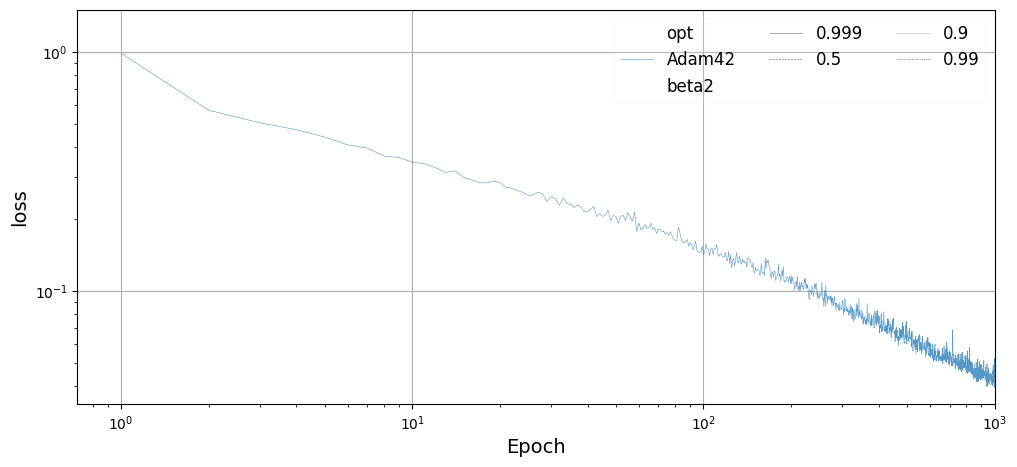

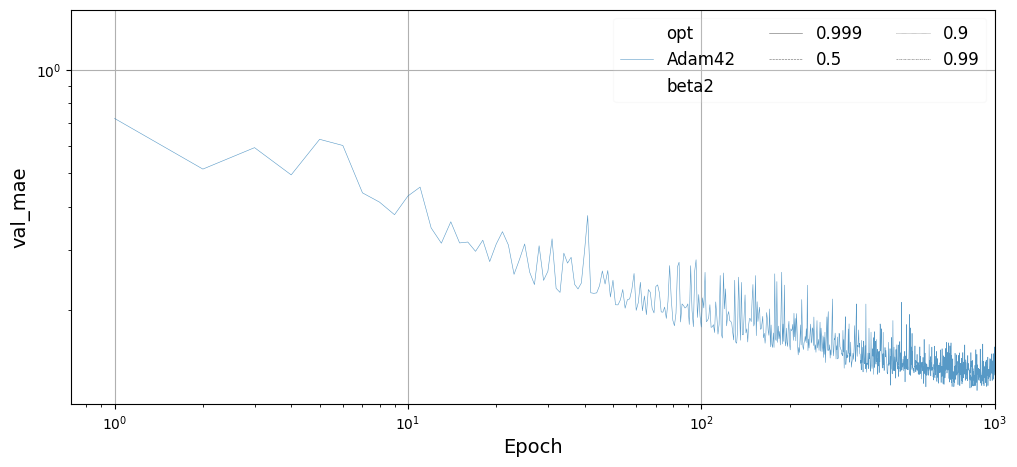

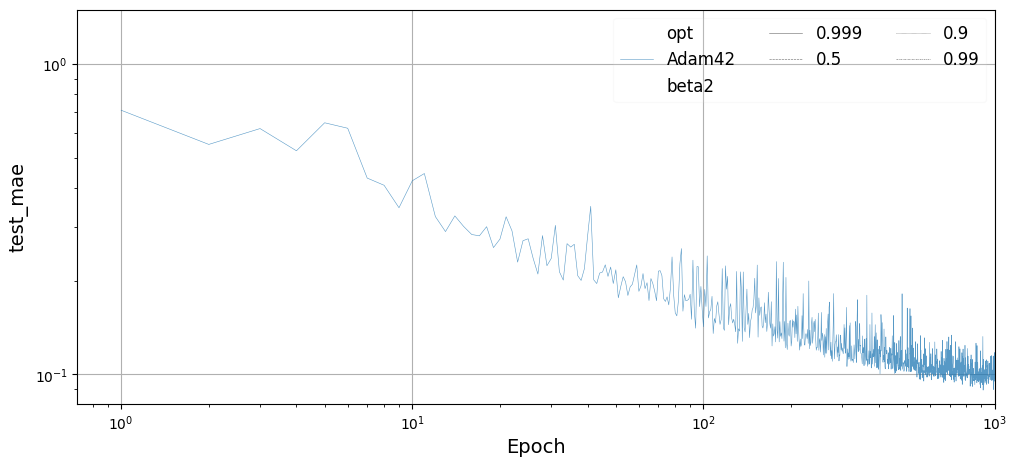

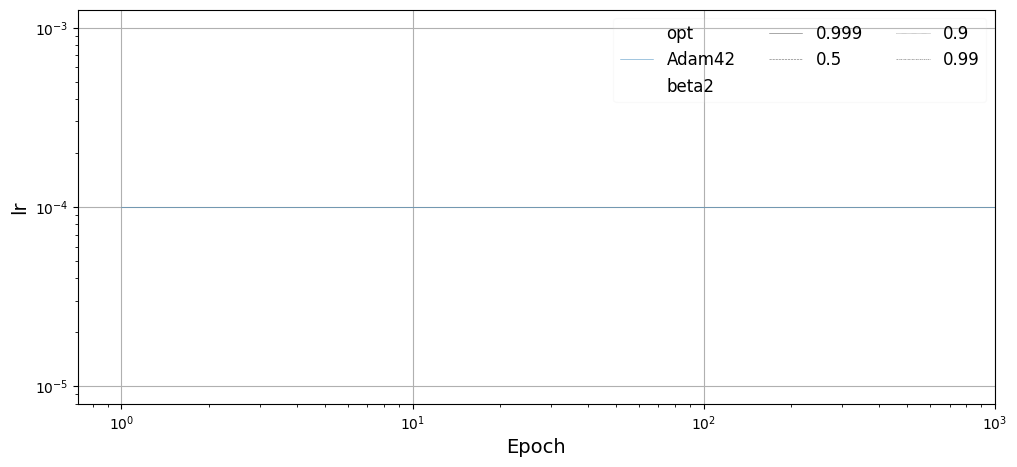

In [16]:
item = "score"
# seedstr = seed + eps
seedstr = "seed51e1000"
# seedstr = "seed23e600"
# seedstr = "seed100"


df_tmp = df
# df_tmp= df_tmp[df_tmp["beta2"]=="0.9"]
# df_tmp= df_tmp[df_tmp["seed"]==seedstr]
# df_tmp= df[df["env"]=="lander"]
for item in ["loss", "val_mae", "test_mae","lr"]: 
# for item in ["score", "pwr_noise", "m", "g"]: 
    fname = '../fig/{}_{}_{}.pdf'.format(games[0], seedstr, item)
    # fname = '../fig/{}_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 4.5))
    
    sns.lineplot(
        data=df_tmp, 
        x="epoch", 
        # x="time", 
        y=item, 
        hue="opt",
        # hue_order=["Adam", "AdamPlus0.9", "AdamPlus0.99",  "AdamPlus0.999", "amsgrad", "AdaGrad", "AdaBelief", "AdaBound", "Lion", "adopt"],
        # hue_order=["Adam", "AdamPlus-3dB", "AdamPlus-10.0dB",  "AdamPlus-30.0dB", "amsgrad", "AdaGrad", "AdaBelief", "AdaBound", "Lion", "adopt"],
        # hue_order=["Adam", "AdamPlus", "Lamb", "LambPlus", "AMSGrad", "Adam41",  "AdaBelief",  "Lion","Adam2",  "Adopt"],
        # hue_order=["Adam", "AdamPlus", "Lamb", "LambPlus", "Adam21", "Adam41",  "Adam+",  "Lion","Adam2",  "Adopt"],
        hue_order=["Adam42"],
        # style="agent",
        # style_order=["DQN", "VanillaDQN"],
        style="beta2",
        # style_order=["0.999","0.5","0.9","0.901", "0.902", "0.903"],
        style_order=["0.999","0.5","0.9","0.99", ], # "0.501", 
        palette="tab10", 
        errorbar=None,
    #     markers=["o", "p", "*"],
        # markersize=14,
    #     dashes=False,
    #     linestyle="dotted",
        ax=ax,
        linewidth=0.4,
        alpha=0.75,
    )
    
    
    
    L = ax.legend(
        fontsize=12,
        framealpha=0.1,
        ncol=3,
        # loc='upper right',
    #     loc='lower right',
    )

    plt.yscale("log")
    plt.xscale("log")
    if item not in ["lr"]:
    # ax.set_ylim([-2, 25])
    # ax.get_legend().remove()
        ax.set_ylim([None, 1.5])
    ax.set_xlim([None, 1000])
    ax.grid(True)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(item, fontsize=14)
    
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    # fig.savefig(fname,
    #             dpi=300,  # facecolor='w', edgecolor='w',
    #             orientation='portrait',
    #             format='pdf')


In [901]:
outdir="./output/"
csvfiles = os.listdir(outdir)
df = pd.DataFrame([])
# games = ["zincStep"]
games = ["zinc"]
lrs = ["1.0e-04"]
seeds = ["35"]
betas = ["0.9", "0.99", "0.999"]
dbs = ["0.0", "-3", "-3.0", "-10.0", "-30.0"]
# dbs = ["-3.0", "-10.0", "-30.0"]
# dbs = ["-3"]
# betas = ["0.9"]
# game="lander"
# game="pong"
# game="breakout"
# game="spaceinvaders"
for csvfile in csvfiles:
    if ".csv" not in csvfile:
        continue
    cfgs = csvfile[0:-4].split("_")
    env, optimizer, learning_rate, beta1, beta2, seed, db, eps = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5], cfgs[6], cfgs[7] 
    if env not in games:
        continue
    if learning_rate not in lrs:
        continue
    if db not in dbs:
        continue
    if eps not in ["e600"]:
        continue
    # if optimizer=="AdamPlus" and db=="-3":
    #     continue
    # if beta2 not in betas:
    #     continue
    if seed[4:] not in seeds:
        continue
    if db == "-10.0":
        optimizer = optimizer + db + "dB"        
    # elif "Adam2" in optimizer:
    #     optimizer = optimizer + db + "dB"
    elif "Adam" in optimizer:
        # optimizer=optimizer + db + "dB"
        optimizer=optimizer + '_' + beta2
    elif "Lamb" in optimizer:
        # optimizer=optimizer + db + "dB"
        optimizer=optimizer + '_' + beta2
    df_tmp = pd.read_csv(os.path.join(outdir, csvfile), index_col=0)
    df_tmp["env"] = env
    df_tmp["optimizer"] = optimizer
    df_tmp["learning_rate"]=learning_rate
    df_tmp["beta1"]=beta1
    df_tmp["beta2"]=beta2
    df_tmp["seed"]= seed
    df = pd.concat([df, df_tmp], ignore_index=False)
    print(csvfile[0:-4])

# df = df.reset_index()
df = df.reset_index(drop=True)
df

zinc_AdaBelief_1.0e-04_0.9_0.999_seed35_-30.0_e600
zinc_Adam_1.0e-04_0.8_0.8_seed35_-30.0_e600
zinc_Adam2_1.0e-04_0.5_0.5_seed35_-30.0_e600
zinc_AdamPlus_1.0e-04_0.9_0.999_seed35_-30.0_e600
zinc_AdamPlus_1.0e-04_0.9_0.9_seed35_-30.0_e600
zinc_Adam_1.0e-04_0.9_0.999_seed35_-30.0_e600
zinc_Lamb_1.0e-04_0.9_0.9_seed35_-30.0_e600
zinc_Lamb_1.0e-04_0.9_0.999_seed35_-30.0_e600
zinc_Adam_1.0e-04_0.5_0.5_seed35_-30.0_e600
zinc_Adam2_1.0e-04_0.9_0.999_seed35_-30.0_e600
zinc_AdaBound_1.0e-04_0.9_0.999_seed35_-30.0_e600
zinc_Lamb2_1.0e-04_0.9_0.9_seed35_-30.0_e600
zinc_Adam3_1.0e-04_0.9_0.9_seed35_-10.0_e600
zinc_LambPlus_1.0e-04_0.9_0.9_seed35_-30.0_e600
zinc_AMSGrad_1.0e-04_0.9_0.999_seed35_-30.0_e600
zinc_Adopt_1.0e-04_0.9_0.999_seed35_-30.0_e600
zinc_Adam_1.0e-04_0.9_0.9_seed35_-30.0_e600
zinc_Adam2_1.0e-04_0.9_0.9_seed35_-30.0_e600
zinc_Adam2_1.0e-04_0.8_0.8_seed35_-30.0_e600
zinc_AdamPlus_1.0e-04_0.9_0.9_seed35_-10.0_e600
zinc_Adam4_1.0e-04_0.9_0.9_seed35_-30.0_e600_batch_128
zinc_Lion_1.0e

,epoch,loss,val_mae,test_mae,lr,opt,env,optimizer,learning_rate,beta1,beta2,seed
0,1,0.740779,0.536104,0.577983,0.0001,AdaBelief,zinc,AdaBelief,1.0e-04,0.9,0.999,seed35
1,2,0.573953,0.521451,0.524292,0.0001,AdaBelief,zinc,AdaBelief,1.0e-04,0.9,0.999,seed35
2,3,0.530668,0.448410,0.457545,0.0001,AdaBelief,zinc,AdaBelief,1.0e-04,0.9,0.999,seed35
3,4,0.492418,0.435803,0.431498,0.0001,AdaBelief,zinc,AdaBelief,1.0e-04,0.9,0.999,seed35
4,5,0.460297,0.441081,0.422059,0.0001,AdaBelief,zinc,AdaBelief,1.0e-04,0.9,0.999,seed35
...,...,...,...,...,...,...,...,...,...,...,...,...
10731,595,0.054261,0.138128,0.108062,0.0001,AdamPlus,zinc,AdamPlus_0.8,1.0e-04,0.8,0.8,seed35
10732,596,0.053933,0.143508,0.116640,0.0001,AdamPlus,zinc,AdamPlus_0.8,1.0e-04,0.8,0.8,seed35
10733,597,0.053439,0.134276,0.102222,0.0001,AdamPlus,zinc,AdamPlus_0.8,1.0e-04,0.8,0.8,seed35
10734,598,0.053487,0.164411,0.137250,0.0001,AdamPlus,zinc,AdamPlus_0.8,1.0e-04,0.8,0.8,seed35


../fig/zinc_seed35e600Adams_loss.pdf
../fig/zinc_seed35e600Adams_val_mae.pdf
../fig/zinc_seed35e600Adams_test_mae.pdf
../fig/zinc_seed35e600Adams_lr.pdf


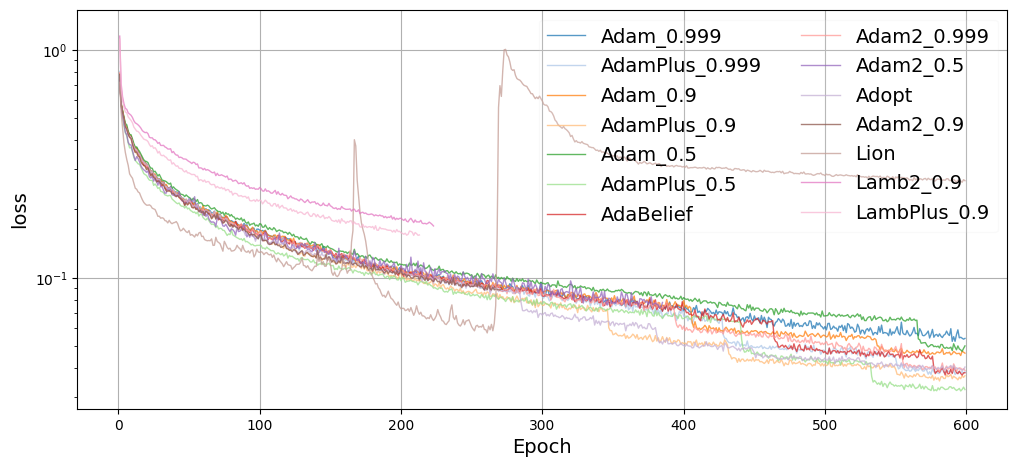

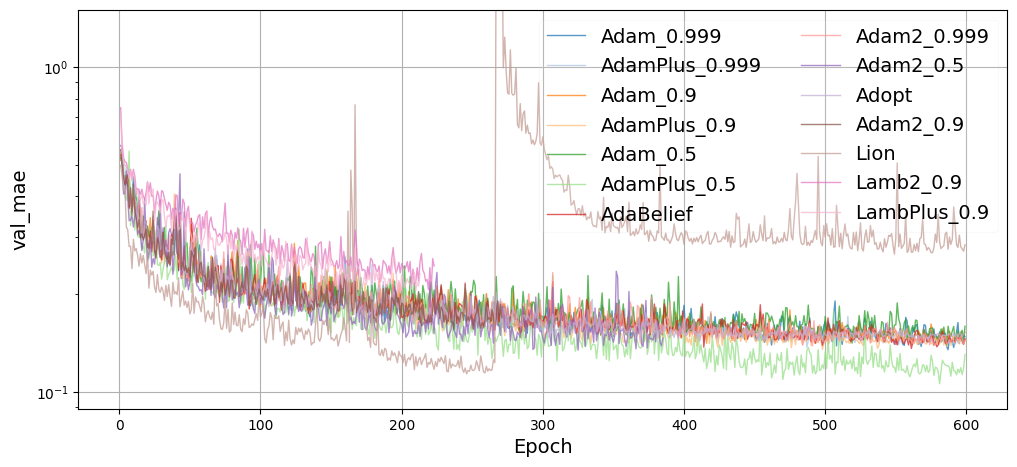

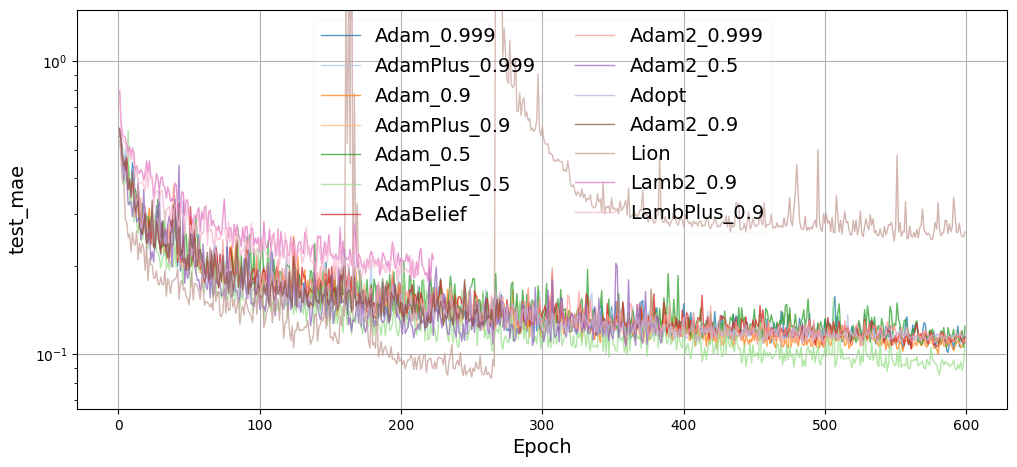

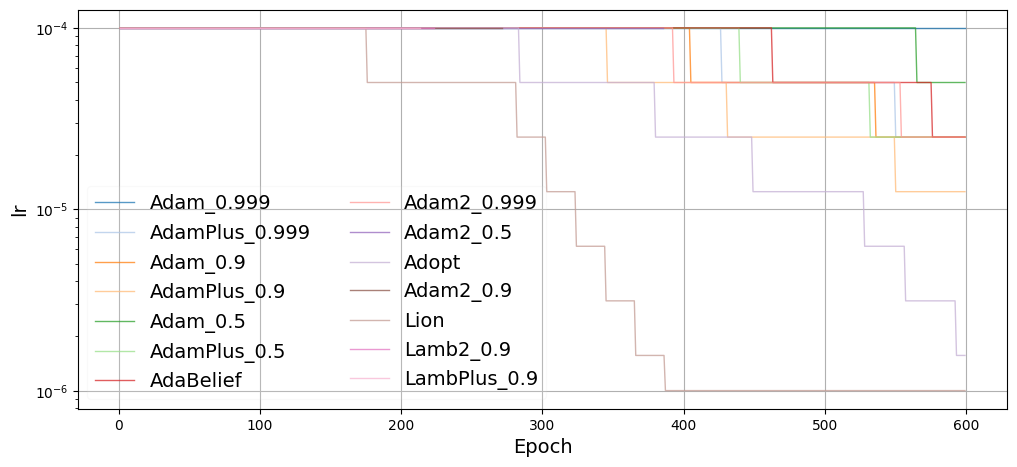

In [902]:
item = "score"
# seedstr = seed + eps
seedstr = "seed35e600Adams"
# seedstr = "seed23e600"
# seedstr = "seed100"


df_tmp = df
# df_tmp= df_tmp[df_tmp["beta2"]=="0.9"]
# df_tmp= df_tmp[df_tmp["seed"]==seedstr]
# df_tmp= df[df["env"]=="lander"]
for item in ["loss", "val_mae", "test_mae","lr"]: 
# for item in ["score", "pwr_noise", "m", "g"]: 
    fname = '../fig/{}_{}_{}.pdf'.format(games[0], seedstr, item)
    # fname = '../fig/{}_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 4.5))
    
    sns.lineplot(
        data=df_tmp, 
        x="epoch", 
        # x="time", 
        y=item, 
        hue="optimizer",
        hue_order=[
            "Adam_0.999", "AdamPlus_0.999", "Adam_0.9", "AdamPlus_0.9", "Adam_0.5", "AdamPlus_0.5", 
            "AdaBelief", 
            "Adam2_0.999", "Adam2_0.5", "Adopt", "Adam2_0.9", "Lion","Lamb2_0.9", "LambPlus_0.9"],
        # hue_order=["Adam_0.999", "Adam2_0.999", "AdamPlus_0.9", "AdamPlus_0.999", "AdamPlus_0.8", "Adam_0.9", "AdaBelief", "Adam_0.8", "Lion", "Adopt"],
#         hue_order=["Adam", "Adam2", "AdamPlus0.9", "Adam3-30.0dB", "AMSgrad", "Adam3-10.0dB", "AdaBelief", "AdaBound", "Lion", "Adopt"],
#         hue_order=["Adam_0.999", "Adam2_0.9", "AdamPlus_0.9", "AdamPlus_0.99", "amsgrad", "AdaGrad", "AdaBelief", "AdaBound", "Lion", "adopt"],
#         hue_order=["Adam_0.999", "Adam2_0.9", "AdamPlus_0.9", "AdamPlus_0.99",  "Lamb_0.999", "Lamb2", "AdaBelief", "AdaBound", "amsgrad", "adopt"],
        # hue_order=["Adam", "AdamPlus0.9", "AdamPlus0.99",  "AdamPlus0.999", "amsgrad", "AdaGrad", "AdaBelief", "AdaBound", "Lion", "adopt"],
        # hue_order=["Adam", "AdamPlus-3dB", "AdamPlus-10.0dB",  "AdamPlus-30.0dB", "amsgrad", "AdaGrad", "AdaBelief", "AdaBound", "Lion", "adopt"],
        # hue_order=["Adam", "AdamPlus-3dB", "AdamPlus-30.0dB", "amsgrad", "AdaGrad", "AdaBelief", "AdaBound", "Lion", "adopt"],
        # style="agent",
        # style_order=["DQN", "VanillaDQN"],
        # style="beta2",
        # style_order=["0.9","0.999"],
        palette="tab20", 
        # errorbar=None,
    #     markers=["o", "p", "*"],
        # markersize=14,
    #     dashes=False,
    #     linestyle="dotted",
        ax=ax,
        linewidth=1,
        alpha=0.75,
    )
    
    
    
    L = ax.legend(
        fontsize=14,
        framealpha=0.1,
        ncol=2,
        # loc='upper right',
    #     loc='lower right',
    )

    plt.yscale("log")
    if item not in ["lr"]:
    # ax.set_ylim([-2, 25])
    # ax.get_legend().remove()
        ax.set_ylim([None, 1.5])
    # ax.set_xlim([0, 5000])
    ax.grid(True)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(item, fontsize=14)
    
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')


In [579]:
# df.to_csv(os.path.join(outdir, "cartpole_DQN_Adam_AdamPlus_betas_2025_04_10.csv"))
# df.to_csv(os.path.join(outdir, "cartpole_VanillaDQN_Adam_AdamPlus_betas_2025_04_10_corrected.csv"))
# df.to_csv(os.path.join(outdir, "{}_VanillaDQN_Adam_AdamPlus_betas_2025_04_12_lr_decay_0.93_100.csv".format(games[0])))

In [696]:
outdir="./output/"
csvfiles = os.listdir(outdir)
df = pd.DataFrame([])
# games = ["zincStep"]
games = ["zinc"]
lrs = ["1.0e-03"]
seeds = ["23"]
betas = ["0.9", "0.99", "0.999"]
dbs = ["0.0", "-3", "-3.0", "-10.0", "-30.0"]
# dbs = ["-3.0", "-10.0", "-30.0"]
# dbs = ["-3"]
# betas = ["0.9"]
# game="lander"
# game="pong"
# game="breakout"
# game="spaceinvaders"
for csvfile in csvfiles:
    if ".csv" not in csvfile:
        continue
    cfgs = csvfile[0:-4].split("_")
    env, optimizer, learning_rate, beta1, beta2, seed, db, eps = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5], cfgs[6], cfgs[7] 
    if env not in games:
        continue
    if learning_rate not in lrs:
        continue
    if db not in dbs:
        continue
    if eps not in ["e600"]:
        continue
    # if optimizer=="AdamPlus" and db=="-3":
    #     continue
    # if beta2 not in betas:
    #     continue
    if seed[4:] not in seeds:
        continue
    if db == "-10.0":
        optimizer = optimizer + db + "dB"        
    # elif "Adam2" in optimizer:
    #     optimizer = optimizer + db + "dB"
    elif "Adam" in optimizer:
        # optimizer=optimizer + db + "dB"
        optimizer=optimizer + '_' + beta2
    elif "Lamb" in optimizer:
        # optimizer=optimizer + db + "dB"
        optimizer=optimizer + '_' + beta2
    df_tmp = pd.read_csv(os.path.join(outdir, csvfile), index_col=0)
    df_tmp["env"] = env
    df_tmp["optimizer"] = optimizer
    df_tmp["learning_rate"]=learning_rate
    df_tmp["beta1"]=beta1
    df_tmp["beta2"]=beta2
    df_tmp["seed"]= seed
    df = pd.concat([df, df_tmp], ignore_index=False)
    print(csvfile[0:-4])

# df = df.reset_index()
df = df.reset_index(drop=True)
df

zinc_Lion_1.0e-03_0.9_0.999_seed23_-30.0_e600
zinc_AdamPlus_1.0e-03_0.9_0.9_seed23_-30.0_e600
zinc_Adam2_1.0e-03_0.9_0.9_seed23_-30.0_e600
zinc_AdaGrad_1.0e-03_0.9_0.999_seed23_-30.0_e600
zinc_Adam_1.0e-03_0.9_0.999_seed23_-30.0_e600
zinc_Adam3_1.0e-03_0.9_0.9_seed23_-10.0_e600
zinc_AdaBelief_1.0e-03_0.9_0.999_seed23_-30.0_e600
zinc_AdamPlus_1.0e-03_0.9_0.99_seed23_-30.0_e600
zinc_Lamb_1.0e-03_0.9_0.999_seed23_-30.0_e600
zinc_amsgrad_1.0e-03_0.9_0.999_seed23_-30.0_e600
zinc_adopt_1.0e-03_0.9_0.999_seed23_-30.0_e600
zinc_Lamb2_1.0e-03_0.9_0.9_seed23_-30.0_e600
zinc_LambPlus_1.0e-03_0.9_0.9_seed23_-30.0_e600
zinc_AdaBound_1.0e-03_0.9_0.999_seed23_-30.0_e600
zinc_Lamb_1.0e-03_0.9_0.9_seed23_-30.0_e600
zinc_AdamPlus_1.0e-03_0.9_0.999_seed23_-30.0_e600


,epoch,loss,val_mae,test_mae,lr,opt,env,optimizer,learning_rate,beta1,beta2,seed
0,1,0.950297,1.366409,1.394282,0.001,Lion,zinc,Lion,1.0e-03,0.9,0.999,seed23
1,2,1.148555,1.161108,1.185750,0.001,Lion,zinc,Lion,1.0e-03,0.9,0.999,seed23
2,3,1.130100,1.129970,1.140918,0.001,Lion,zinc,Lion,1.0e-03,0.9,0.999,seed23
3,4,1.109653,1.113137,1.140516,0.001,Lion,zinc,Lion,1.0e-03,0.9,0.999,seed23
4,5,1.110469,1.139921,1.185837,0.001,Lion,zinc,Lion,1.0e-03,0.9,0.999,seed23
...,...,...,...,...,...,...,...,...,...,...,...,...
8021,94,0.178817,0.206756,0.199895,0.001,AdamPlus,zinc,AdamPlus_0.999,1.0e-03,0.9,0.999,seed23
8022,95,0.219064,0.193362,0.174610,0.001,AdamPlus,zinc,AdamPlus_0.999,1.0e-03,0.9,0.999,seed23
8023,96,0.198885,0.185446,0.168530,0.001,AdamPlus,zinc,AdamPlus_0.999,1.0e-03,0.9,0.999,seed23
8024,97,0.178290,0.173271,0.159533,0.001,AdamPlus,zinc,AdamPlus_0.999,1.0e-03,0.9,0.999,seed23


../fig/zinc_seed23e600_loss.pdf
../fig/zinc_seed23e600_val_mae.pdf
../fig/zinc_seed23e600_test_mae.pdf
../fig/zinc_seed23e600_lr.pdf


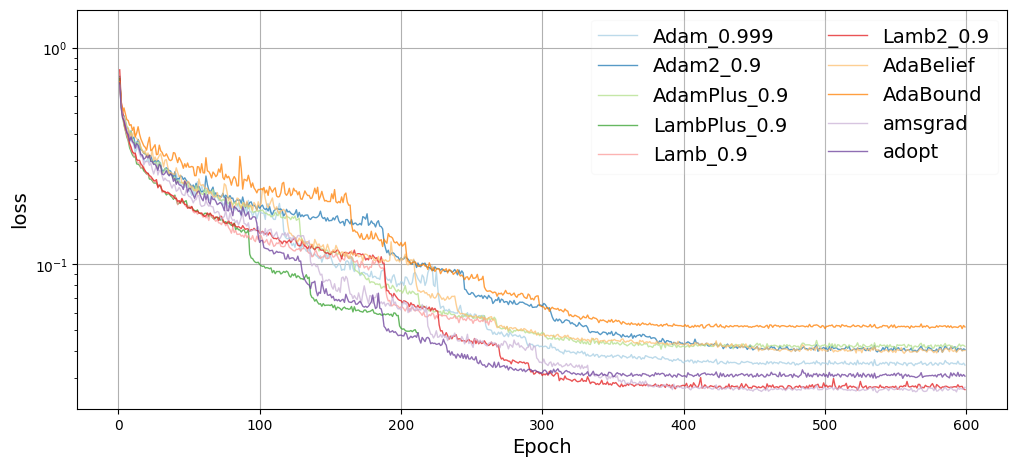

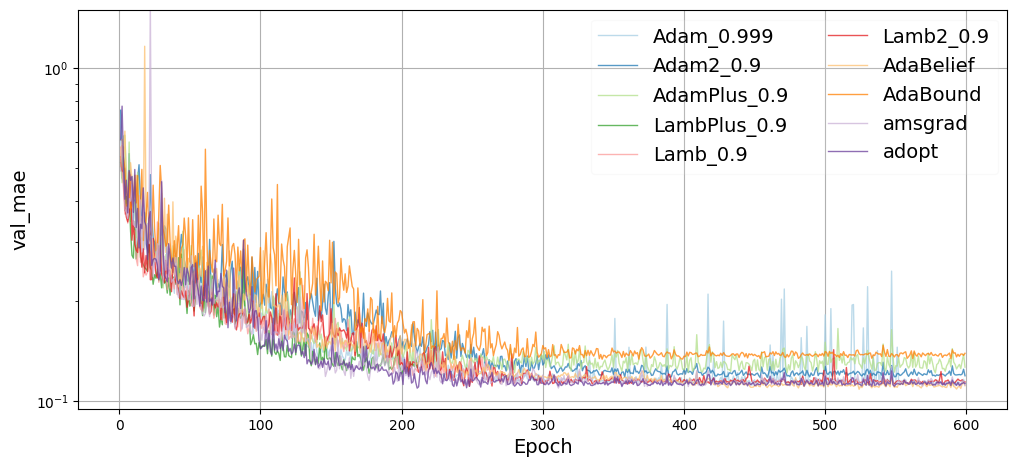

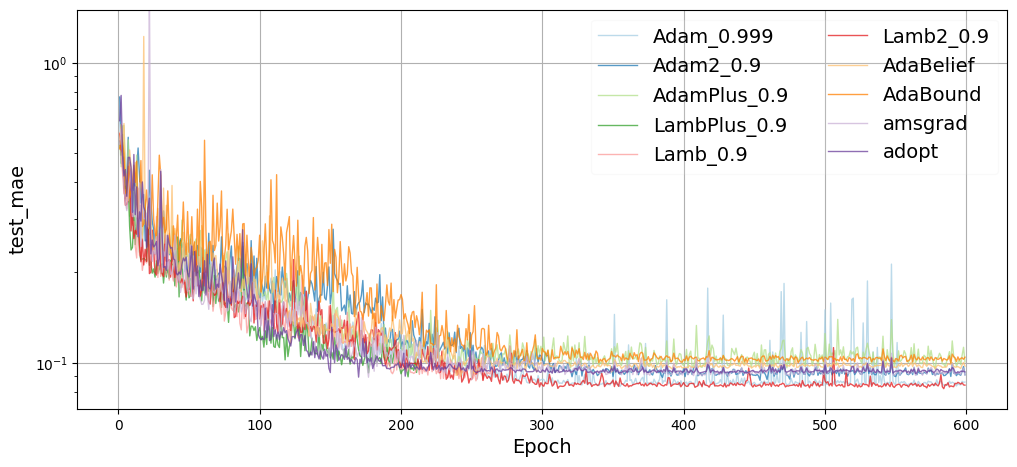

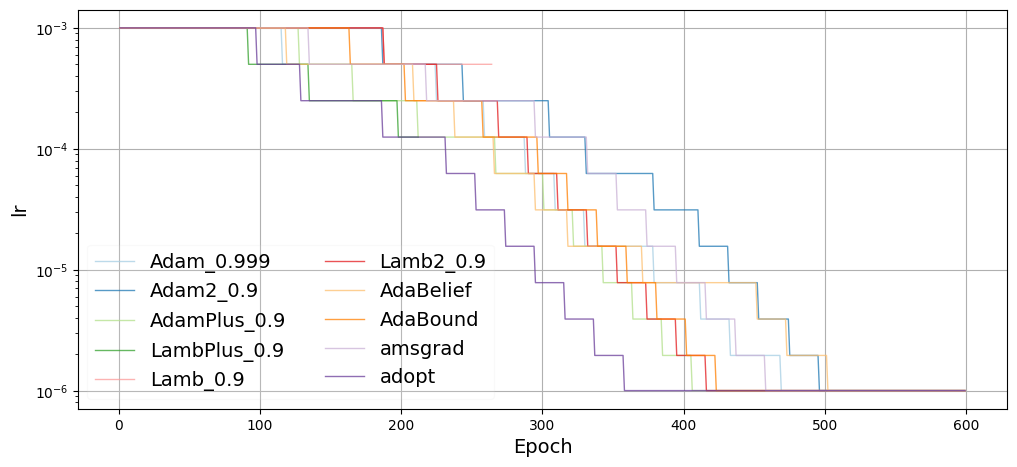

In [698]:
item = "score"
# seedstr = seed + eps
# seedstr = "seed35e600Adams"
seedstr = "seed23e600"
# seedstr = "seed100"


df_tmp = df
# df_tmp= df_tmp[df_tmp["beta2"]=="0.9"]
# df_tmp= df_tmp[df_tmp["seed"]==seedstr]
# df_tmp= df[df["env"]=="lander"]
for item in ["loss", "val_mae", "test_mae","lr"]: 
# for item in ["score", "pwr_noise", "m", "g"]: 
    fname = '../fig/{}_{}_{}.pdf'.format(games[0], seedstr, item)
    # fname = '../fig/{}_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 4.5))
    
    sns.lineplot(
        data=df_tmp, 
        x="epoch", 
        # x="time", 
        y=item, 
        hue="optimizer",
#         hue_order=["Adam_0.999", "AdamPlus_0.999", "Adam_0.9", "AdamPlus_0.9", "Adam_0.8", "AdamPlus_0.8", "AdaBelief", "Lion", "Adam_0.5", "AdamPlus_0.5"],
        # hue_order=["Adam_0.999", "Adam2_0.999", "AdamPlus_0.9", "AdamPlus_0.999", "AdamPlus_0.8", "Adam_0.9", "AdaBelief", "Adam_0.8", "Lion", "Adopt"],
#         hue_order=["Adam", "Adam2", "AdamPlus0.9", "Adam3-30.0dB", "AMSgrad", "Adam3-10.0dB", "AdaBelief", "AdaBound", "Lion", "Adopt"],
#         hue_order=["Adam_0.999", "Adam2_0.9", "AdamPlus_0.9", "AdamPlus_0.99", "amsgrad", "AdaGrad", "AdaBelief", "AdaBound", "Lion", "adopt"],
        hue_order=["Adam_0.999", "Adam2_0.9", "AdamPlus_0.9", "LambPlus_0.9",  "Lamb_0.9", "Lamb2_0.9", "AdaBelief", "AdaBound", "amsgrad", "adopt"],
        # hue_order=["Adam", "AdamPlus0.9", "AdamPlus0.99",  "AdamPlus0.999", "amsgrad", "AdaGrad", "AdaBelief", "AdaBound", "Lion", "adopt"],
        # hue_order=["Adam", "AdamPlus-3dB", "AdamPlus-10.0dB",  "AdamPlus-30.0dB", "amsgrad", "AdaGrad", "AdaBelief", "AdaBound", "Lion", "adopt"],
        # hue_order=["Adam", "AdamPlus-3dB", "AdamPlus-30.0dB", "amsgrad", "AdaGrad", "AdaBelief", "AdaBound", "Lion", "adopt"],
        # style="agent",
        # style_order=["DQN", "VanillaDQN"],
        # style="beta2",
        # style_order=["0.9","0.999"],
        palette="Paired", 
        # errorbar=None,
    #     markers=["o", "p", "*"],
        # markersize=14,
    #     dashes=False,
    #     linestyle="dotted",
        ax=ax,
        linewidth=1,
        alpha=0.75,
    )
    
    
    
    L = ax.legend(
        fontsize=14,
        framealpha=0.1,
        ncol=2,
        # loc='upper right',
    #     loc='lower right',
    )

    plt.yscale("log")
    if item not in ["lr"]:
    # ax.set_ylim([-2, 25])
    # ax.get_legend().remove()
        ax.set_ylim([None, 1.5])
    # ax.set_xlim([0, 5000])
    ax.grid(True)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(item, fontsize=14)
    
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')
